In [1]:
import os 
import numpy as np
import gudhi as gd  
import pickle as pickle
from pylab import *
from sklearn.neighbors import KernelDensity
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [2]:
def persistence_values(diagram, homology_dimension, inf_replacement):
    persistence_values = np.array([[0, 0]]);
    
    for ii in range(0, len(diagram)):
        dim = diagram[ii][0];
        if dim == homology_dimension:
            if np.isinf(diagram[ii][1][1]):
                birth_death = [diagram[ii][1][0], inf_replacement];
            else:
                birth_death = [diagram[ii][1][0], diagram[ii][1][1]];
            
            persistence_values = np.append(persistence_values, [birth_death], axis = 0);
    
    persistence_values = np.delete(persistence_values, 0, 0);
    return(persistence_values);


def homology_dim_diag(diagram, homology_dimension):
    diag_homology_dim = np.array([[0, (0, 0)]]);
    for ii in range(0, len(diagram)):
        dim = diagram[ii][0];
        if dim == homology_dimension:
            diag_homology_dim = np.append(diag_homology_dim, [diagram[ii]], axis = 0);
        
    diag_homology_dim = np.delete(diag_homology_dim, 0, 0);
    return(diag_homology_dim);


def betty_curve(diagram, homology_dimension, x):
    h = persistence_values(diagram, homology_dimension, np.inf);
    
    betty = np.zeros(len(x));

    for ii in range(0,len(betty)):
        x_ii = x[ii];
        b_ii = 0;
        for jj in range(0,len(h)):
            if ((h[jj][0] <= x_ii) and (x_ii < h[jj][1])):
                b_ii = b_ii + 1;
        betty[ii] = b_ii;
        
    return(betty)


def is_file_perseus(file):
    num_lines = open(file).read().count("\n")
    try:
        f = open(file)
        num_dim = int(f.readline())
        coeff = 1
        for dim in range(0, num_dim):
            try:
                line = int(f.readline())
                coeff *= abs(line)
            except ValueError:
                return False
        if num_lines == (1 + num_dim + coeff):
            return True
        else:
            return False
    except ValueError:
        return False
    

In [3]:
def homology_cc(filename):
    cubical_complex = gd.CubicalComplex(perseus_file=filename)
    result_str = 'Cubical complex is of dimension ' + repr(cubical_complex.dimension()) + ' - ' + \
        repr(cubical_complex.num_simplices()) + ' simplices.'
    print(result_str)
    cubical_complex.num_simplices()
    cubical_complex.dimension()
    BarCodes_cub1 = cubical_complex.persistence(min_persistence=1)
       
    #show the persistence diagram 
    #gd.plot_persistence_barcode(BarCodes_cub1,colormap='blue')
    gd.plot_persistence_diagram(BarCodes_cub1);
    plt.show()

    
    #betti_curves Dimension 0 
    max_diameter = float(80);
    x = np.arange(0, max_diameter, .5);
    b0_rips = betty_curve(BarCodes_cub1, 0, x);
    fig, ax = plt.subplots()
    ax.plot(x, b0_rips)
    #leg = ax.legend();
    #plt.title('H_0 Betti Curve')
    ax.yaxis.set_label_text('Number of Cycles')
    ax.xaxis.set_label_text('Filteration Value')
    np.savetxt(filename + 'betti_0D.csv',np.column_stack((x,b0_rips)))
    plt.show()
    
    
    #betti_curves Dimension 1 
    max_diameter = float(80);     ## max diameter may be varied based on the density height ## 
    x = np.arange(0, max_diameter, .5);
    b1_rips = betty_curve(BarCodes_cub1, 1, x);
    fig, ax = plt.subplots()
    ax.plot(x, b1_rips)
    #leg = ax.legend();
    #plt.title('H_0 Betti Curve')
    ax.yaxis.set_label_text('Number of Cycles')
    ax.xaxis.set_label_text('Filteration Value')
    np.savetxt(filename + 'betti_1D.csv',np.column_stack((x,b1_rips)))
    plt.show()
    
    
    ## generates life times (death-birth) for dimension 0 (0-D holes or the connected components)
    bd_0 = cubical_complex.persistence_intervals_in_dimension(0)
    #print(bd)
    #birth1 = bd[:][:5]
    birth0=[]
    for i in bd_0:
        birth0.append(i[0])
    #print(birth1)
    death0 = []
    for i in bd_0:
        death0.append(i[1])
    #print(death1)
    diff0 = np.array(death0)-np.array(birth0)
    print(diff0)

    
    
     ## save the barcodes (0-D) ##
    gd.plot_persistence_barcode(bd_0,colormap='red')
    plt.xlabel('FV',size='15')
    plt.ylabel(r'$\beta_0$',size='15')
    plt.xlim(0,25)
    plt.title('')
    plt.savefig(filename + 'bar_pd0_0D_edges.png',  dpi=1000)
    plt.show()
        
        
    ## plot lifetimes here 0-D ##
    life0 = plt.hist(diff0[:-1], bins=10);
    plt.ylabel('Counts')
    plt.xlabel('Lifetime')
    hist1 = []
    bins1 = []
    hist,bins,n = plt.hist(diff0[:-1], bins=np.arange(min(diff0[:-1]), max(diff0[:-1]) + 1,1),density= True)
    for i in range(0,len(hist)):
        hist1.append(hist[i])
        bins1.append(bins[i])
    plt.savefig(filename + 'life_0D.pdf', bbox_inches='tight', ppi=1200)
    np.savetxt(filename + 'life_0D.csv',np.column_stack((hist1, bins1)))
    
    ## persistence entropy 0-D ##
    LB0 = np.sum(diff0[:-1])
    li0 = diff0[:-1]/LB0
    logli_over_Lb0 = np.log(li0)
    PEB0 = np.sum(-li0*logli_over_Lb0)
    print(PEB0)
    
    
    ## generates life times (death-birth) for dimension 1 (1-D holes or loops of the circles or the rings)
    bd_1 = cubical_complex.persistence_intervals_in_dimension(1)
    #print(bd_1)
    #birth1 = bd[:][:5]
    birth1=[]
    for i in bd_1:
        birth1.append(i[0])
    #print(birth1)
    death1 = []
    for i in bd_1:
        death1.append(i[1])
    #print(death1)
    diff1 = np.array(death1)-np.array(birth1)
    #print(diff1)    
    
    
    ## save the barcodes (1-D) ##
    gd.plot_persistence_barcode(bd_1,colormap='blue')
    plt.xlabel('FV',size='15')
    plt.ylabel(r'$\beta_1$',size='15')
    plt.xlim(0,25)
    plt.title('')
    plt.savefig(filename + 'bar_1D_cycles.png',  dpi=1000)
    plt.show()    

    ## plot lifetimes here 1-D ##
    life1 = plt.hist(diff1, bins=50);
    plt.ylabel('Counts')
    plt.xlabel('Lifetime')
    hist1 = []
    bins1 = []
    hist,bins,n = plt.hist(diff1[:-1], bins=np.arange(min(diff1[:-1]), max(diff1[:-1]) + 1,1),density= True)
    for i in range(0,len(hist)):
        hist1.append(hist[i])
        bins1.append(bins[i])
    plt.savefig(filename + 'life_1D.pdf', bbox_inches='tight', ppi=1200)
    np.savetxt(filename + 'life_1D.csv',np.column_stack((hist1, bins1)))
    
    ## persistence entropy 1-D ##
    LB1 = np.sum(diff1)
    #print(LB1)
    li1 = diff1/LB1
    logli_over_Lb1 = np.log(li1)
    PEB1 = np.sum(-li1*logli_over_Lb1)
    print(PEB1)


Cubical complex is of dimension 2 - 40401 simplices.


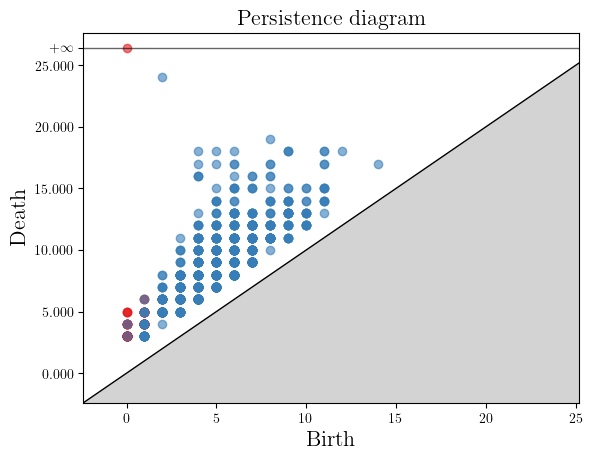

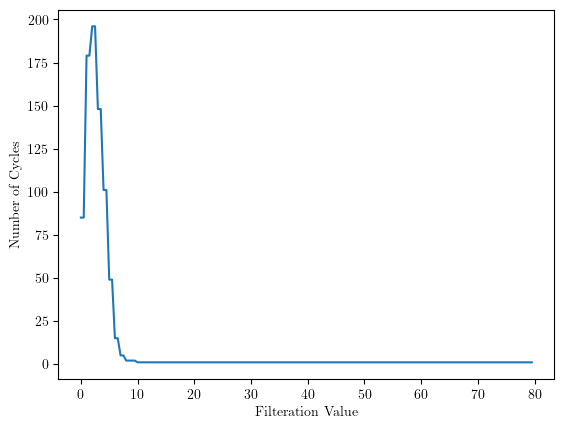

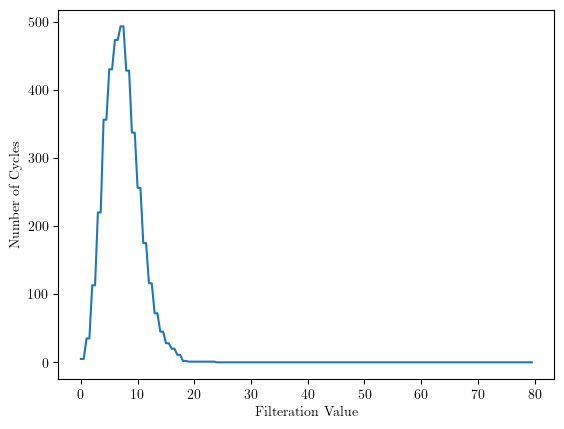

[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  2.  2.  2.
  2.  3.  3.  2.  3.  2.  2.  3.  2.  2.  2.  2.  3.  3.  3.  3.  2.  2.
  2.  3.  2.  2.  2.  2.  3.  2.  2.  3.  2.  2.  3.  2.  2.  2.  3.  2.
  3.  3.  2.  2.  2.  2.  3.  2.  2.  3.  2.  2.  2.  2.  2.  2.  2.  3.
  2.  2.  2.  2.  3.  2.  3.  3.  3.  2.  3.  3.  2.  2.  2.  3.  3.  2.
  3.  2.  2.  2.  2.  2.  3.  2.  2.  2.  4.  2.  3.  2.  2.  3.  4.  2.
  3.  2.  2.  2.  2.  3.  2.  2.  2.  2.  3.  2.  2.  3.  2.  3.  2.  2.
  3.  2.  4.  2.  4.  3.  2.  2.  2.  4.  3.  3.  2.  3.  4.  2.  2.  3.
  2.  2.  3.  2.  3.  3.  3.  3.  4.  2.  3.  3.  2.  2.  3.  3.  2.  2.
  3.  2.  2.  2.  4.  3.  5.  2.  4.  4.  2.  2.  4.  2.  5.  4.  2.  3.
  2.  4.  3.  2.  3.  4.  2.  3.  3.  2.  3.  2.  4.  2.  2.  3.  2.  2.
  3.  2.  4.  3.  3.  2.  2.  3.  3.  3.  2.  3.  2

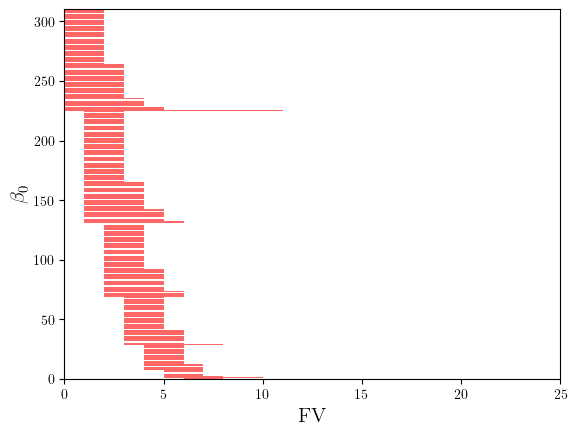

/var/folders/8m/51f6d5xd0sxcw71b7vdxrm300000gp/T/ipykernel_38929/2332607491.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename + 'life_0D.pdf', bbox_inches='tight', ppi=1200)


5.695051992042874


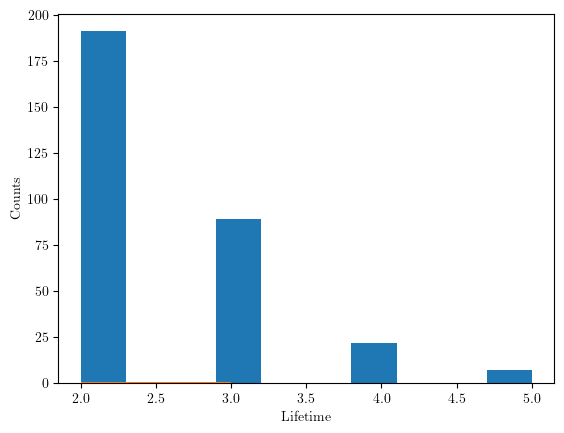

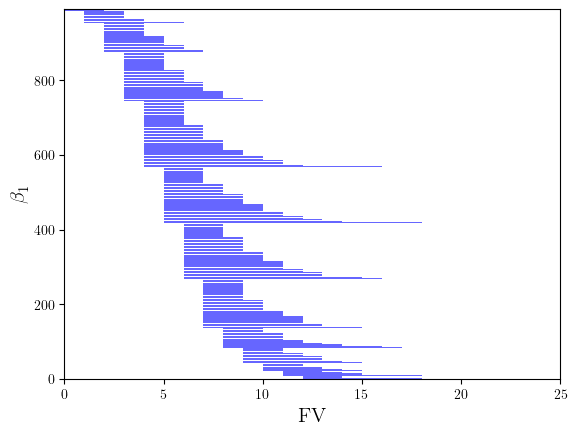

/var/folders/8m/51f6d5xd0sxcw71b7vdxrm300000gp/T/ipykernel_38929/2332607491.py:127: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename + 'life_1D.pdf', bbox_inches='tight', ppi=1200)


6.776275158720518


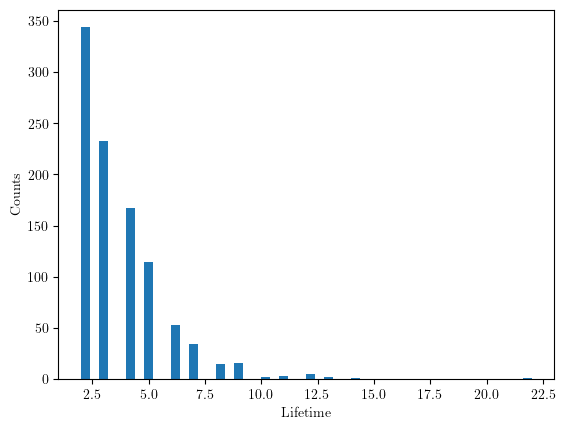

In [4]:
homology_cc('density_for_homology_test3.csv')